In [2]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import sys
import pickle
import argparse
import networkx as nx
import operator

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from collections import defaultdict

from torch.autograd import Variable
from models.models import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result


In [3]:
graphs = {"regnet": RegNetGraph(), "genemania": GeneManiaGraph()}


Torrent name: regnet.pkl, Size: 8.81MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 0 finished pieces out of 269 total pieces.
BT:0, Web:0 |--------------------------------------------------| 0.0% (0.00kB/s)

KeyboardInterrupt: 

In [4]:
# Setup the results dictionary
filename = "experiments/results/graph-gen.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size', 'optimize_graph_results'])
    print("Created a New Results Dictionary")


[Errno 2] No such file or directory: 'experiments/results/graph-gen.pkl'
Created a New Results Dictionary


In [5]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
models = {"BasicMLP": MLP(column_names=dataset.df.columns, dropout=False, cuda=cuda)}


In [8]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), models.keys(), range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 195600
done: 0


In [15]:
def optimize_graph(model, gene_graph, gene, X_train, X_test, y_train, y_test):
    neighbors = list(gene_graph.first_degree(gene)[0])
    neighbors = [n for n in neighbors if n in X_train.columns.values]
    res = {}
    for neighbor in neighbors:
        candidate_nodes = neighbors if gene == neighbor else set(neighbors) - set(neighbor)
        x_train = X_train.loc[:, candidate_nodes].copy()
        x_test = X_test.loc[:, candidate_nodes].copy()
        x_train[gene] = 1
        x_test[gene] = 1

        try:
            model.fit(x_train, y_train)
            x_test = Variable(torch.FloatTensor(np.expand_dims(x_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
            res[neighbor] = auc
            model.best_model = None # cleanup

        except Exception as e:
            print(e)
    return res


In [17]:
optimize_graph_results = []

for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = models[model_name]

    experiment = {
        "gene": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
        "optimize_graph_results": None,
    }
    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError:
        results = record_result(results, experiment, filename)
        continue

    if is_first_degree:
        gene_graph = graphs[graph_name]
        experiment["optimize_graph_results"] = optimize_graph(model, gene_graph, gene, X_train, X_test, y_train, y_test)
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()

        X_train[gene] = 1
        X_test[gene] = 1

        try:
            model.fit(X_train, y_train)

            x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
            model.best_model = None # cleanup
            experiment["auc"] = auc
        except Exception as e:
            print(e)
    results = record_result(results, experiment, filename)


40
50
60
70
80
90
'NoneType' object has no attribute 'copy'
100
110
120
130
140
150
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in tha

KeyboardInterrupt: 

In [18]:
results

,auc,gene,model,graph,is_first_degree,seed,train_size,optimize_graph_results
0,NaN,UBE2Q1,BasicMLP,genemania,True,0,50,"{'KIAA0368': 0.5150952704451346, 'RNF26': 0.61..."
1,0.704233,UBE2Q1,BasicMLP,genemania,False,0,50,None
2,NaN,UBE2Q1,BasicMLP,genemania,True,1,50,"{'KIAA0368': 0.5278936982401656, 'RNF26': 0.57..."
3,0.644115,UBE2Q1,BasicMLP,genemania,False,1,50,None
4,NaN,UBE2Q1,BasicMLP,genemania,True,2,50,"{'KIAA0368': 0.4436626552795031, 'RNF26': 0.46..."
5,0.673705,UBE2Q1,BasicMLP,genemania,False,2,50,None
6,NaN,UBE2Q1,BasicMLP,regnet,True,0,50,"{'POLR3C': 0.7879989971532091, 'ARL3': 0.75818..."
7,0.692846,UBE2Q1,BasicMLP,regnet,False,0,50,None
8,NaN,UBE2Q1,BasicMLP,regnet,True,1,50,"{'POLR3C': 0.8241783126293996, 'ARL3': 0.81399..."
9,0.622473,UBE2Q1,BasicMLP,regnet,False,1,50,None


In [1]:
results["max_auc"] = ""
for idx, result in results[results["is_first_degree"]][results["graph"] == "genemania"].iterrows():
    max_auc = 0
    gene_to_record = result["gene"]
    for gene, auc in result["optimize_graph_results"].items():
        if auc > max_auc:
            max_auc = auc
            gene_to_record = gene
        if gene == result["gene"]:
            results.at[idx, 'auc'] = auc
    results.at[idx, 'gene_to_record'] = gene_to_record
    results.at[idx, 'max_auc'] = max_auc



NameError: name 'results' is not defined

In [69]:
res = defaultdict(list)
for i, result in results[results.gene == "UBE2Q1"][results.is_first_degree][results["graph"] == "regnet"].iterrows():# [results["graph"] == "genemania"]:
    for gene, auc in result["optimize_graph_results"].items():
        res[gene].append(auc)


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [84]:
means = {}
variances = {}
for gene, vals in res.items():
    means[gene] = mean(vals)
    variances[gene] = np.var(vals)

In [72]:
for gene, values in res.items():
    res[gene] = np.array(values)


In [73]:
sorted_x = sorted(means.items(), key=operator.itemgetter(1))

In [106]:
means["PSMA2"]

0.8138737248749137

In [74]:
mean_values = [x[1] for x in sorted_x]
mean_keys = [x[0] for x in sorted_x]

In [117]:
genes = list(variances.keys())

In [ ]:
regnet = RegNetGraph()

In [153]:
adj = regnet.nx_graph["UBE2Q1"]


In [156]:
adj = np.asarray(nx.to_numpy_matrix(regnet.nx_graph))

In [158]:
adj[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [155]:
nx.to_numpy_matrix(regnet.nx_graph)["UBE2Q1"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [131]:
nodes = regnet.nx_graph.edges(genes, data="weight")

In [152]:
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
regnet_results, regnet_labels, nodes = bucket_weights(adj, bins)

> <ipython-input-151-629dd2b6bdcd>(13)bucket_weights()
-> subgraph = ((adj > x) & (adj <= x + 0.1))


(Pdb)  x


0.0


(Pdb)  adj


AtlasView(OrderedDict([('SNRPE', OrderedDict([('weight', 0.00989999994635582)])), ('PPP4C', OrderedDict([('weight', 0.00989999994635582)])), ('C16orf71', OrderedDict([('weight', 0.01600000075995922)])), ('ARAF', OrderedDict([('weight', 0.01600000075995922)])), ('ATP5G3', OrderedDict([('weight', 0.009999999776482582)])), ('POLB', OrderedDict([('weight', 0.014000000432133675)])), ('SUN1', OrderedDict([('weight', 0.014000000432133675)])), ('NCBP2', OrderedDict([('weight', 0.01600000075995922)])), ('TADA1', OrderedDict([('weight', 0.014000000432133675)])), ('TPR', OrderedDict([('weight', 0.01600000075995922)])), ('SDHC', OrderedDict([('weight', 0.009999999776482582)])), ('GLRX2', OrderedDict([('weight', 0.014999999664723873)])), ('VPS41', OrderedDict([('weight', 0.019999999552965164)])), ('UBL4A', OrderedDict([('weight', 0.01899999938905239)])), ('HAX1', OrderedDict([('weight', 0.012000000104308128)])), ('PHB2', OrderedDict([('weight', 0.006899999920278788)])), ('SCAND1', OrderedDict([('we

(Pdb)  l


  8  	
  9  	    results = []
 10  	    nodes = {}
 11  	    for x in bins:
 12  	        import pdb; pdb.set_trace()
 13  ->	        subgraph = ((adj > x) & (adj <= x + 0.1))
 14  	        results.append(subgraph.sum())
 15  	        nodes[x] = subgraph
 16  	    return results, labels, nodes
 17  	
 18  	


(Pdb)  adj.to_numpy_matrix


*** AttributeError: 'AtlasView' object has no attribute 'to_numpy_matrix'


(Pdb)  nx.to_numpy_matrix(adj)


*** AttributeError: 'AtlasView' object has no attribute 'is_directed'


(Pdb)  q


BdbQuit: 

In [138]:
plt.figure(figsize=(9, 9))

plt.bar(x=regnet_labels, height=regnet_results)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket")
plt.xlim=1.0

plt.tight_layout()
plt.show()

NameError: name 'regnet_labels' is not defined

<Figure size 648x648 with 0 Axes>

In [137]:
max_edge_weight = {}
i=0
for b in bins:
    for node1, node2 in np.argwhere(nodes[b]):
        max_edge_weight[node1] = int(10 * b)
        max_edge_weight[node2] = int(10 * b)
edge_colors = list((np.round(one_gene_adj[adj.nonzero()].flatten(), 1) * 10).astype(int))[::2]
nx.draw(G, node_color=list(max_edge_weight.values()), edge_color=edge_colors, with_labels=True)
print("Clustered by max edge weight")


# Make the chart
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
one_gene_results, one_gene_labels, nodes = bucket_weights(one_gene_adj, bins)
plt.figure(figsize=(9, 9))
plt.bar(x=one_gene_labels, height=one_gene_results)
plt.title("Histogram of Edge Weights for a BFS Resulting in 50 genes near TERT")
plt.xlabel("Value of Edge Weight")
plt.ylabel("Number of Edges in Bucket")
plt.xticks(bins*10, labels=one_gene_labels[1:])
plt.show()

NameError: name 'bins' is not defined

(0.75, 0.85)

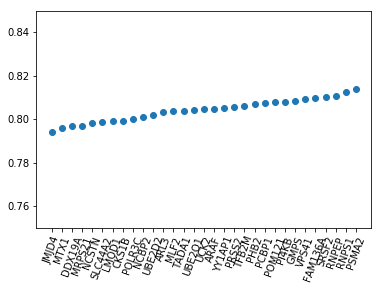

In [95]:
plt.scatter(y=mean_values[::2], x=mean_keys[::2])
axes = plt.gca()
plt.errorbar(y=list(variances.values())[::2], x=mean_keys[::2])
plt.xticks(rotation=70)
axes.set_ylim((0.75, 0.85))



In [14]:
perf = sorted(means.items(), key=operator.itemgetter(1), reverse=True)
genes = [item for item, value in perf]
print(genes)

['IRF2BPL', 'USP11', 'UBE2Q1', 'STUB1', 'SNW1', 'LYPD3', 'C1QTNF2', 'RNF7', 'RNF26', 'KIAA0368', 'TCEAL1', 'UBC', 'TP53', 'FHL3', 'EXOSC7']


In [15]:
neighbors = list(gene_graph.first_degree(gene)[0])

NameError: name 'gene_graph' is not defined

In [173]:
neighbors

['STUB1',
 'TCEAL1',
 'USP11',
 'TP53',
 'KIAA0368',
 'EXOSC7',
 'RNF26',
 'UBE2Q1',
 'UBC',
 'FHL3',
 'RNF7',
 'SNW1',
 'LYPD3',
 'IRF2BPL',
 'C1QTNF2']